In [8]:
import sys
sys.path.append('../')

from game_runner import NegotitaionGame, GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prompting.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)



In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [11]:
rounds = []
p1_values = []
p2_values = []
max_rounds = 5
p1_offers = []
p2_offers = []
game = NegotitaionGame(
    player1_agent=llm_agent.LLMAgent(),
    player2_agent=llm_agent.LLMAgent(),
    num_items=10,
    item_value_range=[0, 101],
    gamma=0.9,
    max_rounds=max_rounds,
    outside_offer_value_range=[1, 1000]
)

rounds = []
p1_values = []
p2_values = []

#LOOP TO RUN NEGOTIATION
while game.in_progress:  
    current_step = len(game.history[0]) + len(game.history[1]) + 1
    current_round = (current_step - 1) // 2 + 1 
    current_player = 1 if current_step % 2 == 1 else 2
    
    print(f"\n{'='*80}")
    print(f"Round {current_round}, Player {current_player}'s turn (Step {current_step})")
    print(f"{'='*80}")

    prev_offer = game.current_offer  
    game.step()  
    
    if game.current_offer: #NORMAL ROUNDS
        p1_kept = game.items - np.array(game.current_offer.offer)
        p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
        p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        
        if current_player == 2: #PLAYER 2 OFFERS
            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            p1_offers.append(prev_offer.offer)  
            p2_offers.append(game.current_offer.offer)
            print(f"\nRound {current_round} Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")
    
    
    if current_round == game.max_rounds and current_player == 2: #IF WE ARE ON THE LAST ROUND
        if game.current_offer and game.current_offer != prev_offer: #IF PLAYER 2 MAKES A COUNTEROFFER WE TREAT IT AS WALK
            print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
            p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
            p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
            print("\nGame ended after max rounds - both players get outside offers")
        elif game.current_offer == prev_offer: #IF PLAYER 2 ACCEPTS
            print("\nPlayer 2's final action: ACCEPT")
            p1_kept = game.items - np.array(game.current_offer.offer)
            p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
            p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        else: #IF PLAYER 2 WALKS
            print("\nPlayer 2's final action: WALK")
            p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
            p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
            print("\nGame ended after max rounds - both players get outside offers")
        
        game.in_progress = False
        print(f"\nRound {current_round} Final Values:")
        print(f"Player 1: {p1_value:.2f}")
        print(f"Player 2: {p2_value:.2f}")
        
        rounds.append(current_round)
        p1_values.append(p1_value)
        p2_values.append(p2_value)
        break

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")


Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 10 types of items, called item 1 through item 10.
    There are 7 units of item 1, 2 units of item 2, 6 units of item 3, 3 units of item 4, 2 units of item 5, 4 units of item 6, 3 units of item 7, 5 units of item 8, 3 units of item 9, 6 units of item 10 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 90 for item 1, 72 for item 2, 0 for item 3, 10 for item 4, 55 for item 5, 47 for item 6, 36 for item 7, 72 for item 8, 12 for item 9, 91 for item 10.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 30.

    The negotiation proceeds in

## Discounted Values Over Time

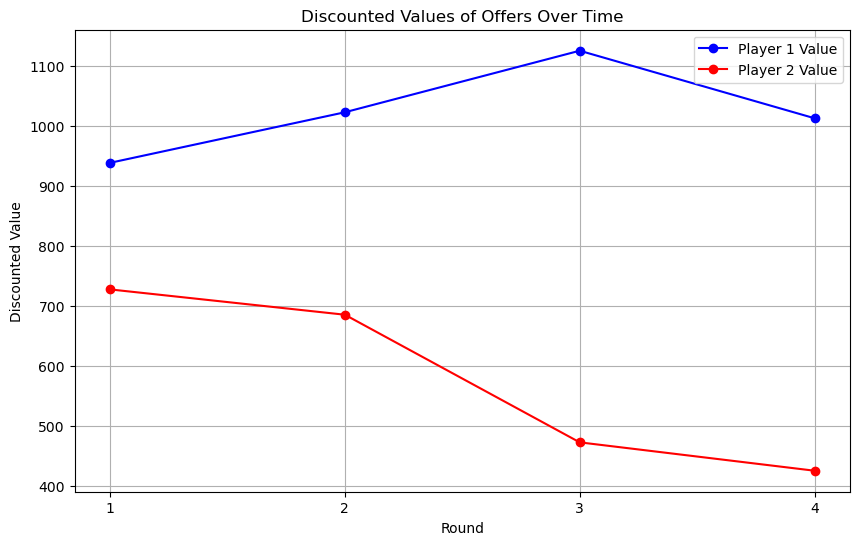


Final Values:
Player 1: 1013.31
Player 2: 425.74


In [12]:
plot_discounted_values(rounds, p1_values, p2_values, max_rounds)

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")

## Offer Evolution

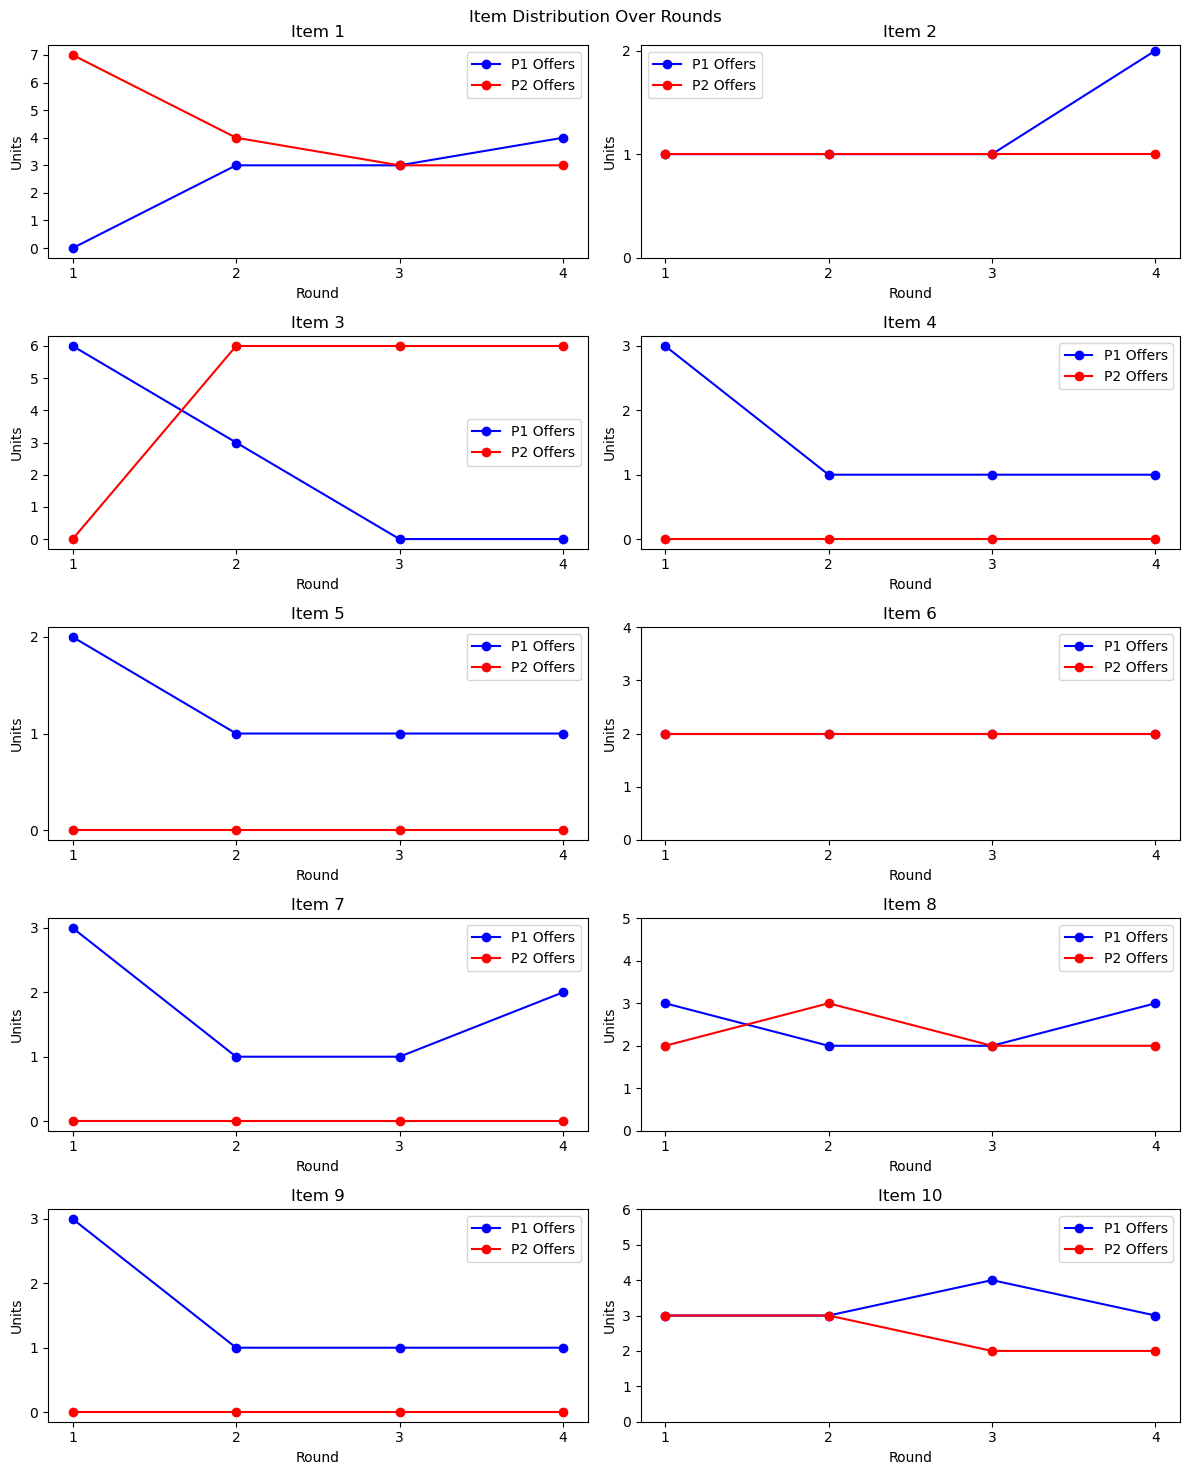

In [13]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

## Negotiation Gap

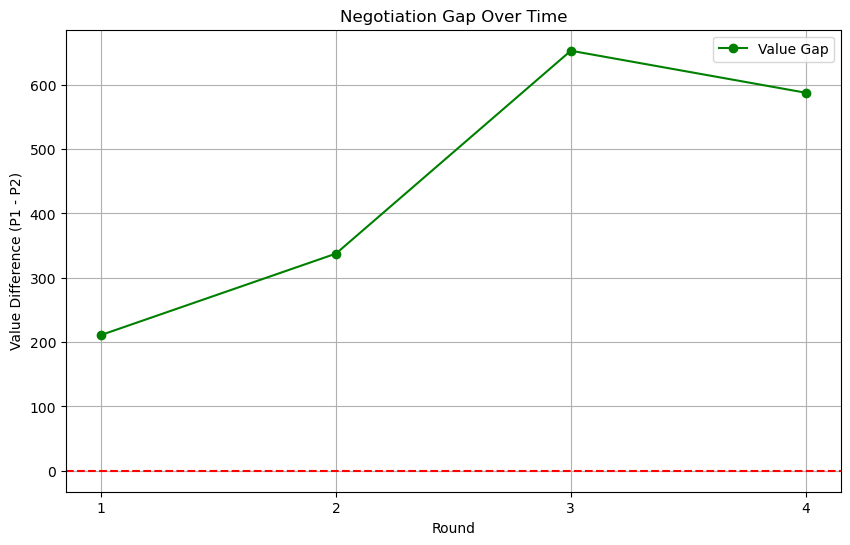

[211.0, 337.5, 652.8600000000001, 587.5740000000001]

In [14]:
plot_negotiation_gap(rounds, p1_values, p2_values)

## Basic Fairness



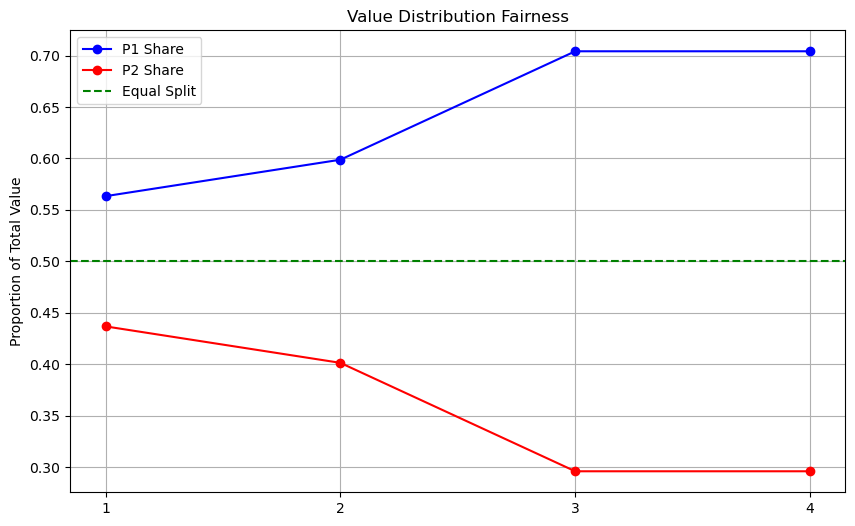

[(0.5632873425314937, 0.4367126574685063),
 (0.5987361769352291, 0.40126382306477093),
 (0.7041540020263425, 0.29584599797365757),
 (0.7041540020263425, 0.2958459979736575)]

In [15]:
plot_fairness(rounds, p1_values, p2_values)

In [16]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()
final_division = get_final_division(game)
final_division = get_final_division(game)
value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)]  # Add this line
fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  # Add this line

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print("\nBasic Metrics:")
print(f"Final P1 Value: {p1_values[-1]:.2f}")
print(f"Final P2 Value: {p2_values[-1]:.2f}")
print(f"Final Value Gap: {value_gaps[-1]:.2f}")
print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
print("\nFinal Division of Items:")
if final_division:
    print(f"Total Items Available: {game.items}")
    print(f"P1 Received: {final_division['P1']}")
    print(f"P2 Received: {final_division['P2']}")
else:
    print("No deal reached - no items were divided")


Negotiation Evaluation:
Outside Offer Rational: Yes

Basic Metrics:
Final P1 Value: 1013.31
Final P2 Value: 425.74
Final Value Gap: 587.57
Final Fairness Ratio: 0.70 : 0.30

Final Division of Items:
Total Items Available: [7 2 6 3 2 4 3 5 3 6]
P1 Received: [4, 1, 0, 3, 2, 2, 3, 3, 3, 4]
P2 Received: [3, 1, 6, 0, 0, 2, 0, 2, 0, 2]
